In [2]:
import os
from dataclasses import dataclass
from pathlib import Path
from typing import List

In [3]:
os.chdir("..")

In [4]:
@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    training_data_path: Path
    pretrained_model_path: Path
    model_filename: str
    augmentation: bool
    batch_size: int
    epochs: int
    image_size: List

In [5]:
from cnnClassifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from cnnClassifier.utils.common import read_yaml, create_directories

In [6]:
class ConfigManager:

    def __init__(self,
                 config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_training_config(self) -> TrainingConfig:
        config = self.config.training

        training_config = TrainingConfig(
            root_dir=config.root_dir,
            training_data_path=config.training_data_path,
            pretrained_model_path=config.pretrained_model_path,
            model_filename=config.model_filename,
            augmentation=self.params.AUGMENTATION,
            batch_size=self.params.BATCH_SIZE,
            epochs=self.params.EPOCHS,
            image_size=self.params.IMAGE_SIZE
        )

        return training_config

In [7]:
import os
import tensorflow as tf
from cnnClassifier.exception import CustomException
from cnnClassifier.logger import logging

In [8]:
class Training:

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.model = None
        self.train_generator = None
        self.valid_generator = None
        self.get_base_model()

    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(self.config.pretrained_model_path)
    
    @staticmethod
    def save_model(model: tf.keras.Model, path: Path):
        model.save(path)
    
    def _train_valid_generator(self):

        data_generator_kwargs = dict(
            rescale=1./255,
            validation_split = 0.2
        )

        valid_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_generator_kwargs)

        dataflow_kwargs = dict(
            target_size = self.config.image_size[:-1],
            batch_size = self.config.batch_size,
            interpolation="bilinear"
        )

        self.valid_generator = valid_data_generator.flow_from_directory(
            self.config.training_data_path,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.augmentation:
            train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=15,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.1,
                zoom_range=0.1,
                **data_generator_kwargs
            )
        else:
            train_data_generator = valid_data_generator
        
        self.train_generator = train_data_generator.flow_from_directory(
            directory=self.config.training_data_path,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )
    
    def train(self):
        train_steps = self.train_generator.samples // self.train_generator.batch_size
        validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            epochs = self.config.epochs,
            steps_per_epoch = train_steps,
            validation_data=self.valid_generator,
            validation_steps=validation_steps
        )
        path = os.path.join(self.config.root_dir, self.config.model_filename)

        self.save_model(model=self.model, path=path)

        return history


    


In [9]:
try:
    config = ConfigManager()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training._train_valid_generator()
    history = training.train()
    
except Exception as e:
    raise e

2024-07-21 17:45:10.439657: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-21 17:45:10.439682: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-21 17:45:10.439688: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-21 17:45:10.439895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-21 17:45:10.439910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 68 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Epoch 1/8


2024-07-21 17:45:11.462569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.4420 - accuracy: 0.5956

2024-07-21 17:45:14.939597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 4s 211ms/step - loss: 2.4420 - accuracy: 0.5956 - val_loss: 0.2775 - val_accuracy: 0.8594
Epoch 2/8
17/17 [==============================] - 4s 203ms/step - loss: 0.8001 - accuracy: 0.7610 - val_loss: 0.2904 - val_accuracy: 0.8750
Epoch 3/8
17/17 [==============================] - 3s 197ms/step - loss: 0.6922 - accuracy: 0.7606 - val_loss: 0.2955 - val_accuracy: 0.8750
Epoch 4/8
17/17 [==============================] - 3s 195ms/step - loss: 0.2522 - accuracy: 0.8958 - val_loss: 0.1006 - val_accuracy: 0.9688
Epoch 5/8
17/17 [==============================] - 3s 197ms/step - loss: 0.2326 - accuracy: 0.9073 - val_loss: 0.0747 - val_accuracy: 1.0000
Epoch 6/8
17/17 [==============================] - 3s 196ms/step - loss: 0.1951 - accuracy: 0.9305 - val_loss: 0.0751 - val_accuracy: 1.0000
Epoch 7/8
17/17 [==============================] - 3s 198ms/step - loss: 0.1523 - accuracy: 0.9266 - val_loss: 0.0795 - val_accuracy: 1.0000
Epoch 8/8
17/17 [======

/Users/ngkuissi/miniforge3/envs/chest/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


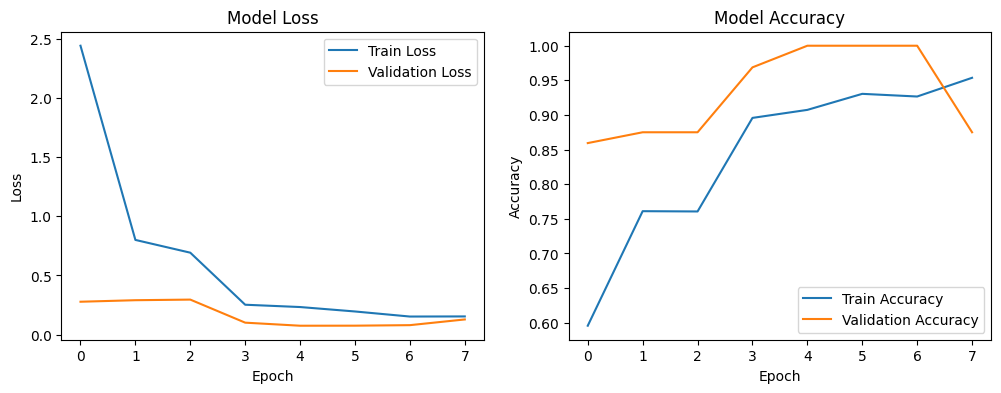

In [10]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [24]:
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np

model = training.model
val_generator = training.valid_generator

y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = val_generator.classes

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

5/5 [==============================] - 1s 164ms/step
Precision: 0.9024
Recall: 0.8824
F1 Score: 0.8784
